<a href="https://colab.research.google.com/github/Rakesh8086/Road-network-extraction/blob/main/u_net_self_and_gated_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

class CustomDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir=None, batch_size=32, target_size=(256, 256), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_filenames = os.listdir(image_dir)

        if mask_dir:
            self.mask_filenames = os.listdir(mask_dir)
            assert len(self.image_filenames) == len(self.mask_filenames), "Number of images and masks must match."
        else:
            self.mask_filenames = None

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError('DataGenerator object is out of range')
        batch_images = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__data_generation(batch_images)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __data_generation(self, batch_images):
        X = np.empty((self.batch_size, *self.target_size, 3))  # Satellite images with 3 channels (RGB)
        if self.mask_dir:
            y = np.empty((self.batch_size, *self.target_size, 1))  # Masks converted to 1 channel
        else:
            y = None

        for i, image_name in enumerate(batch_images):
            # Load and preprocess satellite image (RGB)
            img_path = os.path.join(self.image_dir, image_name)
            image = load_img(img_path, target_size=self.target_size)  # Default is RGB
            X[i,] = img_to_array(image) / 255.0  # Normalize to [0, 1]

            # Load and preprocess mask image (convert RGB to grayscale)
            if self.mask_dir:
                mask_name = image_name.replace('_sat.jpg', '_mask.png')
                mask_path = os.path.join(self.mask_dir, mask_name)
                mask = load_img(mask_path, target_size=self.target_size, color_mode='grayscale')  # Load mask as grayscale
                y[i,] = img_to_array(mask) / 255.0

        return X, y

In [ ]:
train_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/road-extraction-DL/gated-attention-data/train_resize/satellite_resize',
    mask_dir='/content/drive/MyDrive/road-extraction-DL/gated-attention-data/train_resize/mask_resize'
)

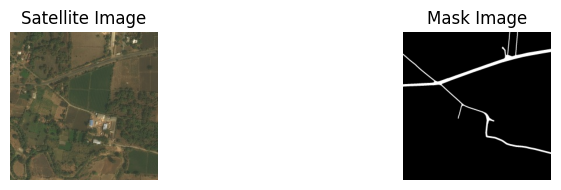

In [ ]:
import matplotlib.pyplot as plt

satellite_images, masks = train_gen[0]  # Get first bactch

num_images = 1

fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 2))

for i in range(num_images):
    # Display satellite image
    axes[i].imshow(satellite_images[i])  # Changed from axes[i, 0] to axes[i]
    axes[i].set_title('Satellite Image')
    axes[i].axis('off')

    # Display mask image
    axes[i+1].imshow(masks[i].squeeze(), cmap='gray')  # Changed from axes[i, 1] to axes[i+1] and added squeeze()
    axes[i+1].set_title('Mask Image')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
total_batches = len(train_gen)
print(f"Total batches in train_gen: {total_batches}")

Total batches in train_gen: 166


In [ ]:
val_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/road-extraction-DL/gated-attention-data/validation_resize/validation_satellite_resize',
    mask_dir='/content/drive/MyDrive/road-extraction-DL/gated-attention-data/validation_resize/validation_mask_resize'
)

In [ ]:
total_batches = len(val_gen)
print(f"Total batches in val_gen: {total_batches}")

Total batches in val_gen: 12


In [ ]:
import tensorflow as tf

In [ ]:
def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection

    return (intersection + smooth) / (union + smooth)

In [ ]:
def iou_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection

    # IoU = intersection / union
    iou = (intersection + smooth) / (union + smooth)

    return 1 - iou

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D

class SelfAttentionLayer(Layer):
    def __init__(self, filters, **kwargs):
        super(SelfAttentionLayer, self).__init__(**kwargs)
        self.filters = filters
        self.q_conv = Conv2D(filters // 8, (1, 1), padding="same")
        self.k_conv = Conv2D(filters // 8, (1, 1), padding="same")
        self.v_conv = Conv2D(filters, (1, 1), padding="same")

    def call(self, x):
        # Compute query, key, value
        q = self.q_conv(x)
        k = self.k_conv(x)
        v = self.v_conv(x)

        # Reshape for batch processing
        batch_size = tf.shape(x)[0]
        height, width = tf.shape(x)[1], tf.shape(x)[2]

        q = tf.reshape(q, (batch_size, height * width, self.filters // 8))
        k = tf.reshape(k, (batch_size, height * width, self.filters // 8))
        v = tf.reshape(v, (batch_size, height * width, self.filters))

        attention = tf.matmul(q, k, transpose_b=True)  # Shape: (batch_size, height * width, height * width)

        attention = tf.nn.softmax(attention, axis=-1)

        # Apply attention to the value matrix
        attention_output = tf.matmul(attention, v)  # Shape: (batch_size, height * width, filters)

        # Reshape back to the original shape of x
        attention_output = tf.reshape(attention_output, tf.shape(x))

        # Add the attention output to the original input (residual connection)
        output = tf.add(attention_output, x)

        return output

In [ ]:
def gated_attention_block(skip_connection_block, upsampling_block):
    # To refine features from the skip connection
    # Compute the attention gate
    g1 = Conv2D(128, kernel_size=(1, 1))(upsampling_block)  # upsampling layer after downsampling
    x1 = Conv2D(128, kernel_size=(1, 1))(skip_connection_block)  # skip connection

    # Concatenate the gating signal and feature map
    concat = tf.keras.layers.Concatenate()([g1, x1])  # Concatenate along the channel axis

    psi = Conv2D(1, kernel_size=(1, 1))(concat)  # 1x1 convolution, to change the no of channels to 1 from 256. 1*1 filter becasue to retain spatial dimensions
    alpha = tf.keras.activations.sigmoid(psi)  # Sigmoid to get attention weights

    # Element-wise multiply with the original feature map
    return skip_connection_block * alpha  # Attention enhanced feature map


In [ ]:
def binary_unet_with_self_and_gated_attention(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    # Input layer
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Downsampling layers
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1) # 128*128 now

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2) # 64*64 now

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3) # 32*32 now

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4) # 16*16 now

    # Bottleneck with self-attention
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    c5 = SelfAttentionLayer(256)(c5)

    # Upsampling layers
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5) # I think here itself it becomes 32*32 and now below
    g1 = gated_attention_block(c4, u6)
    u6 = concatenate([g1, u6]) # 32*32 now
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    g2 = gated_attention_block(c3, u7)
    u7 = concatenate([g2, u7]) # 64*64 now
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    g3 = gated_attention_block(c2, u8)
    u8 = concatenate([g3, u8]) # 128*128 now
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    g4 = gated_attention_block(c1, u9)
    u9 = concatenate([g4, u9]) # 256*256 now
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
model = binary_unet_with_self_and_gated_attention(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_61 (Conv2D)          (None, 256, 256, 16)         448       ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 256, 256, 16)         0         ['conv2d_61[0][0]']           
                                                                                                  
 conv2d_62 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_9[0][0]']           
                                                                                            

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric, iou_loss])

In [ ]:
from keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save at every epoch
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/road-extraction-DL/gated-attention-data/epoch_{epoch:02d}_self_and_gated_attention_model.keras',  # Saving with epoch in the filename
    monitor='val_loss',  # Still monitoring validation loss, but saving at every epoch
    save_best_only=False,  # Save the model at every epoch, not just the best
    mode='min',
    verbose=1
)


In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=8,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/8
166/166 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.9435 - iou_metric: 0.0312 - iou_loss: 0.9688 
Epoch 1: saving model to /content/drive/MyDrive/road-extraction-DL/gated-attention-data/epoch_01_self_and_gated_attention_model.keras
166/166 [==============================] - 2970s 18s/step - loss: 0.1837 - accuracy: 0.9435 - iou_metric: 0.0312 - iou_loss: 0.9688 - val_loss: 0.2531 - val_accuracy: 0.9470 - val_iou_metric: 0.0188 - val_iou_loss: 0.9812
Epoch 2/8
166/166 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9452 - iou_metric: 0.0454 - iou_loss: 0.9546
Epoch 2: saving model to /content/drive/MyDrive/road-extraction-DL/gated-attention-data/epoch_02_self_and_gated_attention_model.keras
166/166 [==============================] - 983s 6s/step - loss: 0.1535 - accuracy: 0.9452 - iou_metric: 0.0454 - iou_loss: 0.9546 - val_loss: 0.1767 - val_accuracy: 0.9475 - val_iou_metric: 0.0355 - val_iou_loss: 0.9645
Epoch 3/8
166/166 [

In [ ]:
model.save('/content/drive/MyDrive/road-extraction-DL/gated-attention-data/u_net_self_and_gated_attention_best_model.keras')

In [ ]:
test_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/road-extraction-DL/gated-attention-data/test_resize',
    mask_dir=None,  # Masks are not needed for testing
    batch_size=1,
    target_size=(256, 256),
    shuffle=False
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
predictions = model.predict(test_gen)

1101/1101 [==============================] - 82s 74ms/step


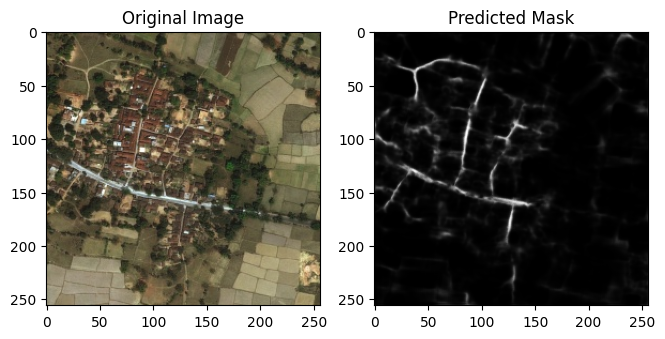

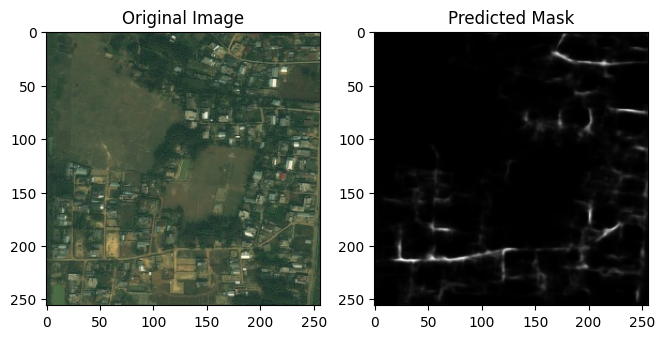

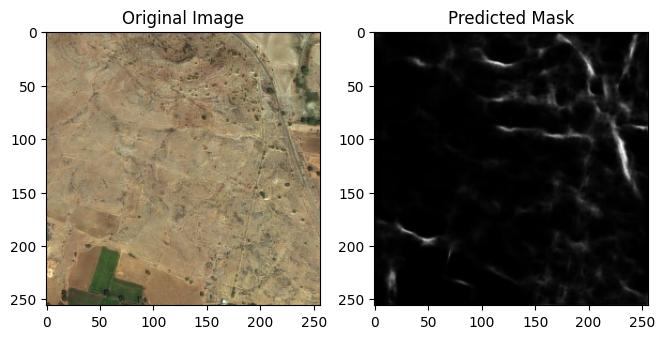

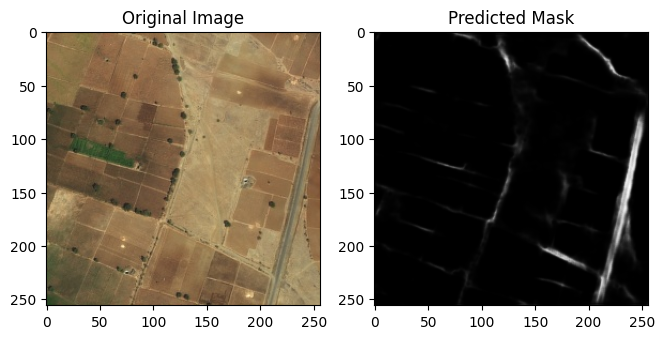

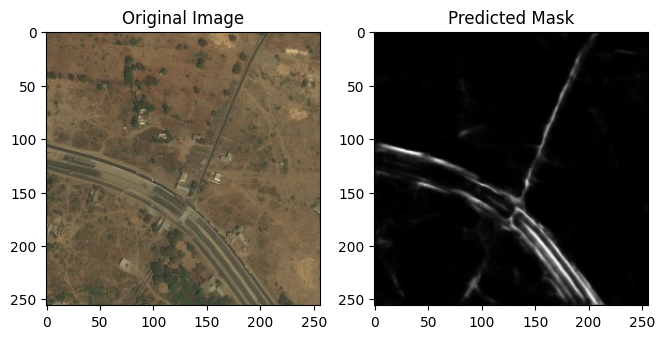

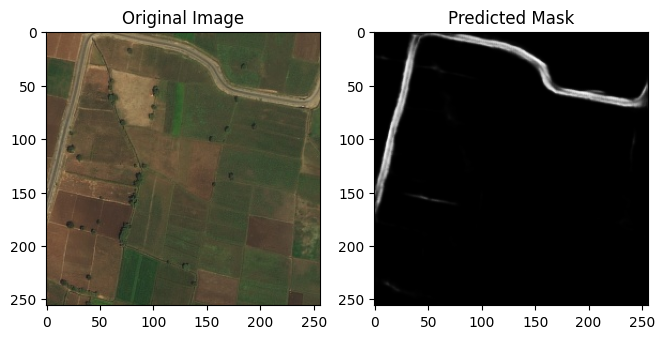

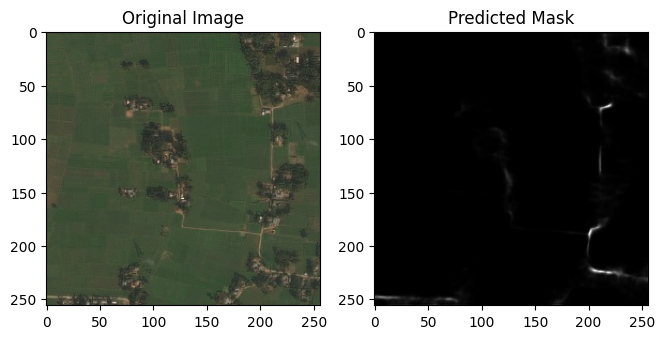

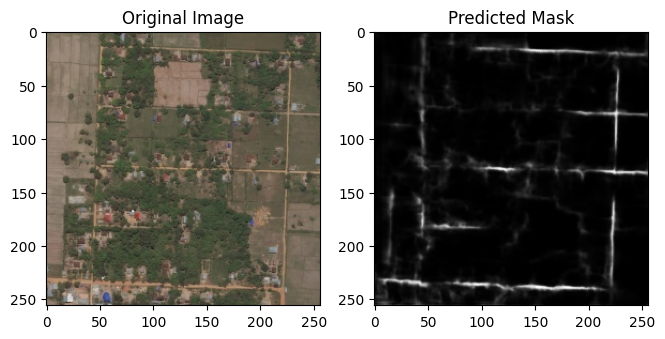

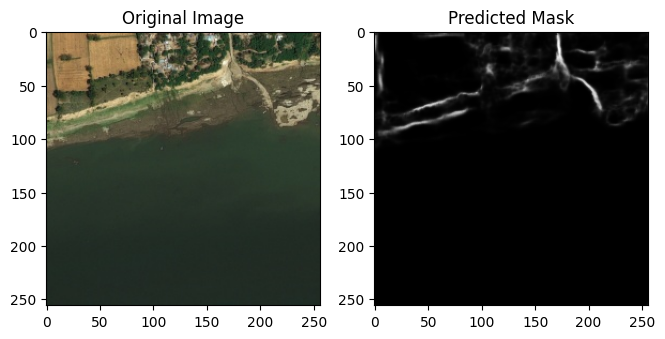

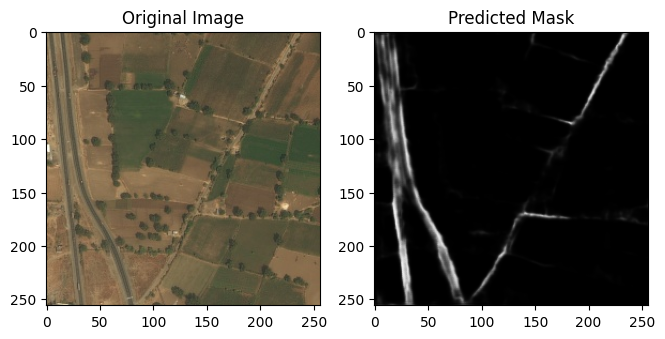

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize some predictions
num_images_to_show = 10  # Adjust as needed

for i in range(num_images_to_show):
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(test_gen[i][0][0])  # Get the first test image
    plt.title('Original Image')

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove channels if needed
    plt.title('Predicted Mask')

    plt.show()

In [ ]:
test_images_dir = '/content/drive/MyDrive/road-extraction-DL/gated-attention-data/new_images'
# Prepare to store predictions
predictions = []

In [ ]:
from PIL import Image

# Loop through each image in the directory
for image_name in os.listdir(test_images_dir):
    img_path = os.path.join(test_images_dir, image_name)

    # Load and preprocess the image
    with Image.open(img_path) as img:
        img_resized = img.resize((256, 256))
        img_array = np.array(img_resized) / 255.0

        # Check if the image has 3 channels (RGB)
        if img_array.shape[-1] == 3:
            img_array = np.expand_dims(img_array, axis=0)

            # Make prediction
            prediction = model.predict(img_array)
            predictions.append(prediction[0])  # Store the prediction (removing batch dimension)
        else:
            print(f"Image {image_name} does not have 3 channels. Skipping...")

# Convert predictions to binary masks
binary_masks = [(pred > 0.5).astype(np.uint8) for pred in predictions]

# Save the predicted masks
output_masks_dir = '/content/drive/MyDrive/road-extraction-DL/gated-attention-data/new_images'
os.makedirs(output_masks_dir, exist_ok=True)

for i, mask in enumerate(binary_masks):
    mask = np.squeeze(mask)  # Remove unnecessary dimensions if any

    # If the mask still has 3 dimensions, take only the first channel
    if len(mask.shape) == 3:
        mask = mask[:, :, 0] # Select the first channel of the mask

    mask_image = Image.fromarray(mask.astype(np.uint8) * 255, mode='L')  # mode='L' ensures a grayscale image
    mask_image.save(os.path.join(output_masks_dir, f"predicted_mask_{i}.png"))

print("Predictions have been made and saved.")

1/1 [==============================] - 0s 91ms/step
Predictions have been made and saved.


In [ ]:
################## Test images ######################

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt

test_image_dir = '/content/drive/MyDrive/road-extraction-DL/gated-attention-data/test_resize'
save_dir = '/content/drive/MyDrive/road-extraction-DL/gated-attention-data/predicted_mask_gated_attention'

os.makedirs(save_dir, exist_ok=True)

test_images = os.listdir(test_image_dir)

for image_name in test_images:
    img_path = os.path.join(test_image_dir, image_name)
    image = load_img(img_path, target_size=(256, 256))
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    # Make prediction
    prediction = model.predict(image_array)

    # Process prediction to binary mask (thresholding)
    predicted_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Binarize the prediction

    mask_save_path = os.path.join(save_dir, f'predicted_mask_{image_name}')
    plt.imsave(mask_save_path, predicted_mask, cmap='gray')  # Save as grayscale image

print("Predictions saved successfully!")


1/1 [==============================] - 0s 86ms/step
Predictions saved successfully!


In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/road-extraction-DL/gated-attention-data/u_net_self_and_gated_attention_best_model.keras',
                   custom_objects={'SelfAttentionLayer': SelfAttentionLayer,
                                   'iou_metric': iou_metric,
                                   'iou_loss': iou_loss}) # Add iou_metric and iou_loss to custom_objects

TypeError: Could not deserialize class 'Functional' because its parent module keras.src.engine.functional cannot be imported. Full object config: {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'model', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 256, 256, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 3]}, 'name': 'conv2d', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 16]}, 'name': 'dropout', 'inbound_nodes': [[['conv2d', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 16]}, 'name': 'conv2d_1', 'inbound_nodes': [[['dropout', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 16]}, 'name': 'max_pooling2d', 'inbound_nodes': [[['conv2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_2', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 16]}, 'name': 'conv2d_2', 'inbound_nodes': [[['max_pooling2d', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_1', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'dropout_1', 'inbound_nodes': [[['conv2d_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'conv2d_3', 'inbound_nodes': [[['dropout_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_1', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'max_pooling2d_1', 'inbound_nodes': [[['conv2d_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_4', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 32]}, 'name': 'conv2d_4', 'inbound_nodes': [[['max_pooling2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_2', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'dropout_2', 'inbound_nodes': [[['conv2d_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_5', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'conv2d_5', 'inbound_nodes': [[['dropout_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_2', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'max_pooling2d_2', 'inbound_nodes': [[['conv2d_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 64]}, 'name': 'conv2d_6', 'inbound_nodes': [[['max_pooling2d_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_3', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'dropout_3', 'inbound_nodes': [[['conv2d_6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_7', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'conv2d_7', 'inbound_nodes': [[['dropout_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_3', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'max_pooling2d_3', 'inbound_nodes': [[['conv2d_7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_8', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 128]}, 'name': 'conv2d_8', 'inbound_nodes': [[['max_pooling2d_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_4', 'trainable': True, 'dtype': 'float32', 'rate': 0.3, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'dropout_4', 'inbound_nodes': [[['conv2d_8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_9', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv2d_9', 'inbound_nodes': [[['dropout_4', 0, 0, {}]]]}, {'module': None, 'class_name': 'SelfAttentionLayer', 'config': {'name': 'self_attention_layer', 'trainable': True, 'dtype': 'float32', 'filters': 256}, 'registered_name': 'SelfAttentionLayer', 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'self_attention_layer', 'inbound_nodes': [[['conv2d_9', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv2d_transpose', 'inbound_nodes': [[['self_attention_layer', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_13', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'conv2d_13', 'inbound_nodes': [[['conv2d_transpose', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_14', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'conv2d_14', 'inbound_nodes': [[['conv2d_7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 32, 128], [None, 32, 32, 128]]}, 'name': 'concatenate', 'inbound_nodes': [[['conv2d_13', 0, 0, {}], ['conv2d_14', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_15', 'trainable': True, 'dtype': 'float32', 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'conv2d_15', 'inbound_nodes': [[['concatenate', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.sigmoid', 'trainable': True, 'dtype': 'float32', 'function': 'math.sigmoid'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 32, 32, 1]}, 'name': 'tf.math.sigmoid', 'inbound_nodes': [['conv2d_15', 0, 0, {}]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply', 'trainable': True, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'tf.math.multiply', 'inbound_nodes': [['conv2d_7', 0, 0, {'y': ['tf.math.sigmoid', 0, 0], 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_1', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 32, 128], [None, 32, 32, 128]]}, 'name': 'concatenate_1', 'inbound_nodes': [[['tf.math.multiply', 0, 0, {}], ['conv2d_transpose', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_16', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'conv2d_16', 'inbound_nodes': [[['concatenate_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_5', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'dropout_5', 'inbound_nodes': [[['conv2d_16', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_17', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'conv2d_17', 'inbound_nodes': [[['dropout_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_1', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'conv2d_transpose_1', 'inbound_nodes': [[['conv2d_17', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_18', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'conv2d_18', 'inbound_nodes': [[['conv2d_transpose_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_19', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'conv2d_19', 'inbound_nodes': [[['conv2d_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_2', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 128], [None, 64, 64, 128]]}, 'name': 'concatenate_2', 'inbound_nodes': [[['conv2d_18', 0, 0, {}], ['conv2d_19', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_20', 'trainable': True, 'dtype': 'float32', 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_20', 'inbound_nodes': [[['concatenate_2', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.sigmoid_1', 'trainable': True, 'dtype': 'float32', 'function': 'math.sigmoid'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 64, 64, 1]}, 'name': 'tf.math.sigmoid_1', 'inbound_nodes': [['conv2d_20', 0, 0, {}]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_1', 'trainable': True, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'tf.math.multiply_1', 'inbound_nodes': [['conv2d_5', 0, 0, {'y': ['tf.math.sigmoid_1', 0, 0], 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_3', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 64], [None, 64, 64, 64]]}, 'name': 'concatenate_3', 'inbound_nodes': [[['tf.math.multiply_1', 0, 0, {}], ['conv2d_transpose_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_21', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'conv2d_21', 'inbound_nodes': [[['concatenate_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_6', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'dropout_6', 'inbound_nodes': [[['conv2d_21', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_22', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'conv2d_22', 'inbound_nodes': [[['dropout_6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_2', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'conv2d_transpose_2', 'inbound_nodes': [[['conv2d_22', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_23', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'conv2d_23', 'inbound_nodes': [[['conv2d_transpose_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_24', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'conv2d_24', 'inbound_nodes': [[['conv2d_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_4', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 128, 128, 128], [None, 128, 128, 128]]}, 'name': 'concatenate_4', 'inbound_nodes': [[['conv2d_23', 0, 0, {}], ['conv2d_24', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_25', 'trainable': True, 'dtype': 'float32', 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 256]}, 'name': 'conv2d_25', 'inbound_nodes': [[['concatenate_4', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.sigmoid_2', 'trainable': True, 'dtype': 'float32', 'function': 'math.sigmoid'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 128, 128, 1]}, 'name': 'tf.math.sigmoid_2', 'inbound_nodes': [['conv2d_25', 0, 0, {}]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_2', 'trainable': True, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'tf.math.multiply_2', 'inbound_nodes': [['conv2d_3', 0, 0, {'y': ['tf.math.sigmoid_2', 0, 0], 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_5', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 128, 128, 32], [None, 128, 128, 32]]}, 'name': 'concatenate_5', 'inbound_nodes': [[['tf.math.multiply_2', 0, 0, {}], ['conv2d_transpose_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_26', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'conv2d_26', 'inbound_nodes': [[['concatenate_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_7', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'dropout_7', 'inbound_nodes': [[['conv2d_26', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_27', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'conv2d_27', 'inbound_nodes': [[['dropout_7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_3', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'conv2d_transpose_3', 'inbound_nodes': [[['conv2d_27', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_28', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 16]}, 'name': 'conv2d_28', 'inbound_nodes': [[['conv2d_transpose_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_29', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 16]}, 'name': 'conv2d_29', 'inbound_nodes': [[['conv2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_6', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 256, 128], [None, 256, 256, 128]]}, 'name': 'concatenate_6', 'inbound_nodes': [[['conv2d_28', 0, 0, {}], ['conv2d_29', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_30', 'trainable': True, 'dtype': 'float32', 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 256]}, 'name': 'conv2d_30', 'inbound_nodes': [[['concatenate_6', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.sigmoid_3', 'trainable': True, 'dtype': 'float32', 'function': 'math.sigmoid'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 256, 256, 1]}, 'name': 'tf.math.sigmoid_3', 'inbound_nodes': [['conv2d_30', 0, 0, {}]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_3', 'trainable': True, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 256, 256, 16]}, 'name': 'tf.math.multiply_3', 'inbound_nodes': [['conv2d_1', 0, 0, {'y': ['tf.math.sigmoid_3', 0, 0], 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_7', 'trainable': True, 'dtype': 'float32', 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 256, 16], [None, 256, 256, 16]]}, 'name': 'concatenate_7', 'inbound_nodes': [[['tf.math.multiply_3', 0, 0, {}], ['conv2d_transpose_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_31', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 32]}, 'name': 'conv2d_31', 'inbound_nodes': [[['concatenate_7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_8', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 16]}, 'name': 'dropout_8', 'inbound_nodes': [[['conv2d_31', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_32', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 16]}, 'name': 'conv2d_32', 'inbound_nodes': [[['dropout_8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_33', 'trainable': True, 'dtype': 'float32', 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 16]}, 'name': 'conv2d_33', 'inbound_nodes': [[['conv2d_32', 0, 0, {}]]]}], 'input_layers': [['input_1', 0, 0]], 'output_layers': [['conv2d_33', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 256, 256, 3]}, 'compile_config': {'optimizer': 'adam', 'loss': 'binary_crossentropy', 'metrics': ['accuracy', {'module': 'builtins', 'class_name': 'function', 'config': 'iou_metric', 'registered_name': 'function'}, {'module': 'builtins', 'class_name': 'function', 'config': 'iou_loss', 'registered_name': 'function'}], 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
test_image_dir = '/content/drive/MyDrive/road-extraction-DL/gated-attention-data/crack'
save_dir = '/content/drive/MyDrive/road-extraction-DL/gated-attention-data/crack'

os.makedirs(save_dir, exist_ok=True)

test_images = os.listdir(test_image_dir)

for image_name in test_images:
    img_path = os.path.join(test_image_dir, image_name)
    image = load_img(img_path, target_size=(256, 256))
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    # Make prediction
    prediction = model.predict(image_array)

    # Process prediction to binary mask (thresholding)
    predicted_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Binarize the prediction

    mask_save_path = os.path.join(save_dir, f'predicted_mask_{image_name}')
    plt.imsave(mask_save_path, predicted_mask, cmap='gray')  # Save as grayscale image

print("Predictions saved successfully!")

1/1 [==============================] - 1s 520ms/step
Predictions saved successfully!


In [ ]:
import os
import numpy as np
from skimage.io import imread
from sklearn.metrics import jaccard_score

In [ ]:
original_mask_folder = '/content/drive/MyDrive/road-extraction-DL/gated-attention-data/500_test_images/new_test_masks'
predicted_mask_folder = '/content/drive/MyDrive/road-extraction-DL/gated-attention-data/500_test_images/new_predicted_masks'

In [ ]:
iou_scores = []
for filename in os.listdir(original_mask_folder):
    if filename.endswith('.png'):
        original_mask_path = os.path.join(original_mask_folder, filename)
        # Extract the number from the original mask name
        mask_number = filename.split('_')[0]
        # Construct the predicted mask name
        predicted_mask_filename = f'predicted_mask_{mask_number}_sat.jpg'
        predicted_mask_path = os.path.join(predicted_mask_folder, predicted_mask_filename)

        original_mask = imread(original_mask_path, as_gray=True)
        predicted_mask = imread(predicted_mask_path, as_gray=True)

        original_mask = (original_mask > 0).astype(int)
        predicted_mask = (predicted_mask > 0).astype(int)

        iou = jaccard_score(original_mask.flatten(), predicted_mask.flatten())
        iou_scores.append(iou)

average_iou = np.mean(iou_scores)
print(f"Average IoU: {average_iou}")

Average IoU: 0.1683265161497545


In [ ]:
import keras
print(keras.__version__)

3.4.1


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [ ]:
!pip install tensorflow==2.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 29.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      